In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

In [2]:
# Generate moons dataset
X, y = make_moons(n_samples=100, noise=0.05, random_state=42)

In [5]:
# Visualize data
def visualize_moons(X, y):
    colors_dict = {0: 'b', 1: 'r'}

    for color in colors_dict.keys():
        idx = np.where(y == color)
        plt.scatter(X[idx, 0], X[idx, 1], c=colors_dict[color], label=color)
    
    plt.legend()
    plt.show()

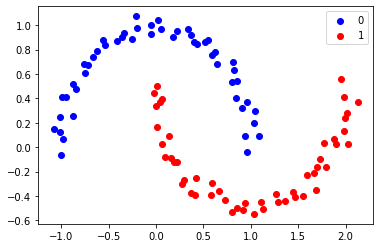

In [6]:
visualize_moons(X, y)

In [7]:
def SVM(X, y, use_v_matrix=False):
    pass